In [1]:
def compute_homography(src, dst):
    """dst ≃ H·src (homogene)."""
    A = []
    for (x, y), (u, v) in zip(src, dst):
        A.extend([
            [-x, -y, -1, 0, 0, 0, u*x, u*y, u],
            [ 0, 0, 0, -x, -y, -1, v*x, v*y, v]
        ])
    A = np.asarray(A, dtype=float)

    _, _, vh = np.linalg.svd(A)
    h = vh[-1] / vh[-1, -1] # Normierung → h33 = 1
    return h.reshape(3, 3)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def calculate_pixel_weights(image_height, image_width):
    j_indices = np.arange(image_height)
    i_indices = np.arange(image_width)
    weight_j = 1.0 - (2.0 / image_height) * np.abs(j_indices - (image_height - 1) / 2.0)
    weight_i = 1.0 - (2.0 / image_width) * np.abs(i_indices - (image_width - 1) / 2.0)
    weight_j[weight_j < 0] = 0
    weight_i[weight_i < 0] = 0
    weights_map = np.outer(weight_j, weight_i)
    return weights_map

def visualize_points(image_points_list, file_paths_list): # Matched your provided signature
    fig, axs = plt.subplots(1, len(file_paths_list), figsize=(5 * len(file_paths_list), 5))
    if len(file_paths_list) == 1:
        axs = [axs]
    for idx, (coords_np_array, fname) in enumerate(zip(image_points_list, file_paths_list)):
        try:
            img = Image.open(fname)
            axs[idx].imshow(img)
            axs[idx].axis('off')
            # coords_np_array is expected to be a NumPy array of shape (N, 2)
            if coords_np_array is not None and coords_np_array.shape[0] > 0:
                x = coords_np_array[:, 0]
                y = coords_np_array[:, 1]
                axs[idx].scatter(x, y, c='r', s=50)
            axs[idx].set_title(f"Image {idx+1}")
        except FileNotFoundError:
            axs[idx].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            axs[idx].set_title(f"Image {idx+1} (not found)")
            axs[idx].axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
# Aufgabe c: Einfache Bildverschmelzung
def blend_images_simple(img1_warped, weights1_warped, img2_warped, weights2_warped, method='weighted_average'):
    if img1_warped.shape != img2_warped.shape:
        raise ValueError("Warped images must have the same dimensions.")
    if weights1_warped.shape != img1_warped.shape[:2] or \
       weights2_warped.shape != img2_warped.shape[:2]:
        raise ValueError("Weight maps must match image dimensions (HxW).")

    blended_image = np.zeros_like(img1_warped, dtype=img1_warped.dtype)
    blended_weights = np.zeros_like(weights1_warped, dtype=weights1_warped.dtype)

    mask1_active_2d = weights1_warped > 1e-6
    mask2_active_2d = weights2_warped > 1e-6

    cond_img1_only = mask1_active_2d & ~mask2_active_2d
    blended_image[cond_img1_only] = img1_warped[cond_img1_only]
    blended_weights[cond_img1_only] = weights1_warped[cond_img1_only]

    cond_img2_only = mask2_active_2d & ~mask1_active_2d
    blended_image[cond_img2_only] = img2_warped[cond_img2_only]
    blended_weights[cond_img2_only] = weights2_warped[cond_img2_only]

    overlap_active_2d = mask1_active_2d & mask2_active_2d
    if np.any(overlap_active_2d):
        if method == 'weighted_average':
            img1_overlap_pixels = img1_warped[overlap_active_2d]
            img2_overlap_pixels = img2_warped[overlap_active_2d]
            w1_overlap_exp = weights1_warped[overlap_active_2d][..., np.newaxis]
            w2_overlap_exp = weights2_warped[overlap_active_2d][..., np.newaxis]

            numerator = img1_overlap_pixels * w1_overlap_exp + img2_overlap_pixels * w2_overlap_exp
            denominator = w1_overlap_exp + w2_overlap_exp

            blended_image[overlap_active_2d] = numerator / (denominator + 1e-9)
            blended_weights[overlap_active_2d] = (weights1_warped + weights2_warped)[overlap_active_2d]

        elif method == 'max_weight':
            w1_values_in_overlap = weights1_warped[overlap_active_2d]
            w2_values_in_overlap = weights2_warped[overlap_active_2d]
            img1_pixels_overlap = img1_warped[overlap_active_2d]
            img2_pixels_overlap = img2_warped[overlap_active_2d]

            temp_blended_overlap_pixels = np.copy(img1_pixels_overlap)
            temp_weights_overlap = np.copy(w1_values_in_overlap)

            cond_w2_takes_precedence = w2_values_in_overlap >= w1_values_in_overlap

            temp_blended_overlap_pixels[cond_w2_takes_precedence] = img2_pixels_overlap[cond_w2_takes_precedence]
            temp_weights_overlap[cond_w2_takes_precedence] = w2_values_in_overlap[cond_w2_takes_precedence]

            blended_image[overlap_active_2d] = temp_blended_overlap_pixels
            blended_weights[overlap_active_2d] = temp_weights_overlap
        else:
            raise ValueError("Unknown blending method. Choose 'weighted_average' or 'max_weight'.")

    return blended_image, blended_weights

In [4]:
# Aufgabe d: Multiband Blending
def blend_images_multiband(img1_warped, weights1_warped, img2_warped, weights2_warped, low_pass_kernel_size=(31, 31)):
    # Ensure float for processing, scale if integer
    if img1_warped.dtype != np.float32 and img1_warped.dtype != np.float64:
        img1_was_int = True
        img1_orig_dtype = img1_warped.dtype
        img1_warped_float = img1_warped.astype(np.float32) / 255.0 if np.issubdtype(img1_warped.dtype, np.integer) else img1_warped.astype(np.float32)
    else:
        img1_was_int = False
        img1_warped_float = img1_warped

    if img2_warped.dtype != np.float32 and img2_warped.dtype != np.float64:
        img2_warped_float = img2_warped.astype(np.float32) / 255.0 if np.issubdtype(img2_warped.dtype, np.integer) else img2_warped.astype(np.float32)
    else:
        img2_warped_float = img2_warped

    lp1 = cv2.GaussianBlur(img1_warped_float, low_pass_kernel_size, 0)
    lp2 = cv2.GaussianBlur(img2_warped_float, low_pass_kernel_size, 0)

    hp1 = img1_warped_float - lp1
    hp2 = img2_warped_float - lp2

    # Blend low-pass components using weighted average and get their combined weights
    blended_lp, blended_lp_weights = blend_images_simple(lp1, weights1_warped, lp2, weights2_warped, method='weighted_average')

    # Blend high-pass components using max_weight for details
    # The weights for HP blending are the original warped weights.
    # The resulting image 'blended_hp' will use pixels from hp1 or hp2 based on these weights.
    # We don't explicitly need a separate 'blended_hp_weights' if the final overall weight map
    # is primarily determined by the low-pass (dominant signal) blending.
    blended_hp = np.zeros_like(hp1, dtype=hp1.dtype)

    w1_2d = weights1_warped
    w2_2d = weights2_warped
    mask1_valid_hp = w1_2d > 1e-6
    mask2_valid_hp = w2_2d > 1e-6

    # Non-overlapping for HP
    cond_hp1_only = mask1_valid_hp & ~mask2_valid_hp
    blended_hp[cond_hp1_only] = hp1[cond_hp1_only]

    cond_hp2_only = mask2_valid_hp & ~mask1_valid_hp
    blended_hp[cond_hp2_only] = hp2[cond_hp2_only]

    # Overlapping for HP (max_weight logic for pixels)
    overlap_mask_hp = mask1_valid_hp & mask2_valid_hp
    if np.any(overlap_mask_hp):
        hp1_overlap_pixels = hp1[overlap_mask_hp]
        hp2_overlap_pixels = hp2[overlap_mask_hp]
        w1_overlap_values = w1_2d[overlap_mask_hp]
        w2_overlap_values = w2_2d[overlap_mask_hp]

        temp_blended_hp_overlap = np.copy(hp1_overlap_pixels)
        cond_hp2_takes_precedence = w2_overlap_values >= w1_overlap_values
        temp_blended_hp_overlap[cond_hp2_takes_precedence] = hp2_overlap_pixels[cond_hp2_takes_precedence]
        blended_hp[overlap_mask_hp] = temp_blended_hp_overlap

    final_blended_image_float = blended_lp + blended_hp

    # Convert back to original type if necessary
    if img1_was_int: # Assuming both images started with similar type characteristics
        final_blended_image = np.clip(final_blended_image_float * 255.0, 0, 255).astype(img1_orig_dtype)
    elif np.all(img1_warped >=0) and np.all(img1_warped <=1) and np.issubdtype(img1_warped.dtype, np.floating):
        final_blended_image = np.clip(final_blended_image_float, 0.0, 1.0)
    else:
        final_blended_image = final_blended_image_float

    # The weights of the multiband blended image are primarily determined by the low-pass blending
    return final_blended_image, blended_lp_weights, blended_hp

In [5]:
# Test

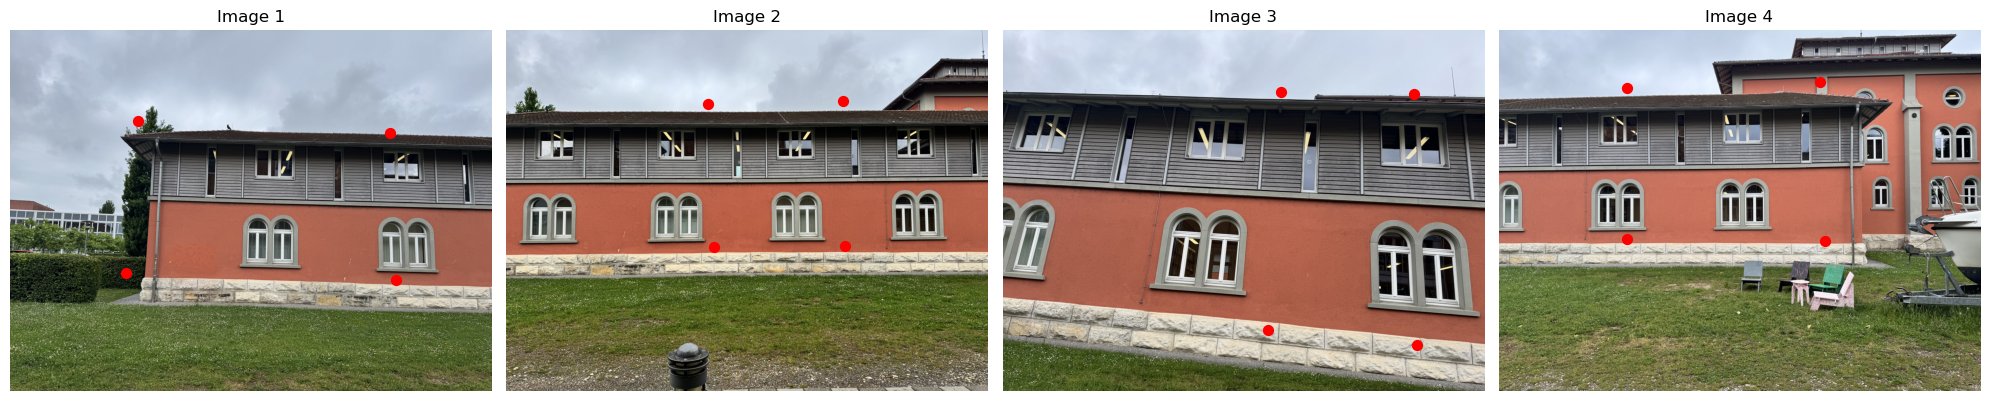


--- Running Panorama Stitching for 4 Images ---
Blending with image 2...
Blending with image 3...


[ WARN:0@5.536] global loadsave.cpp:268 findDecoder imread_('data/stiching/bib_1.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@5.537] global loadsave.cpp:268 findDecoder imread_('data/stiching/bib_2.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@5.539] global loadsave.cpp:268 findDecoder imread_('data/stiching/bib_3.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@5.540] global loadsave.cpp:268 findDecoder imread_('data/stiching/bib_4.jpeg'): can't open/read file: check file path/integrity


Blending with image 4...


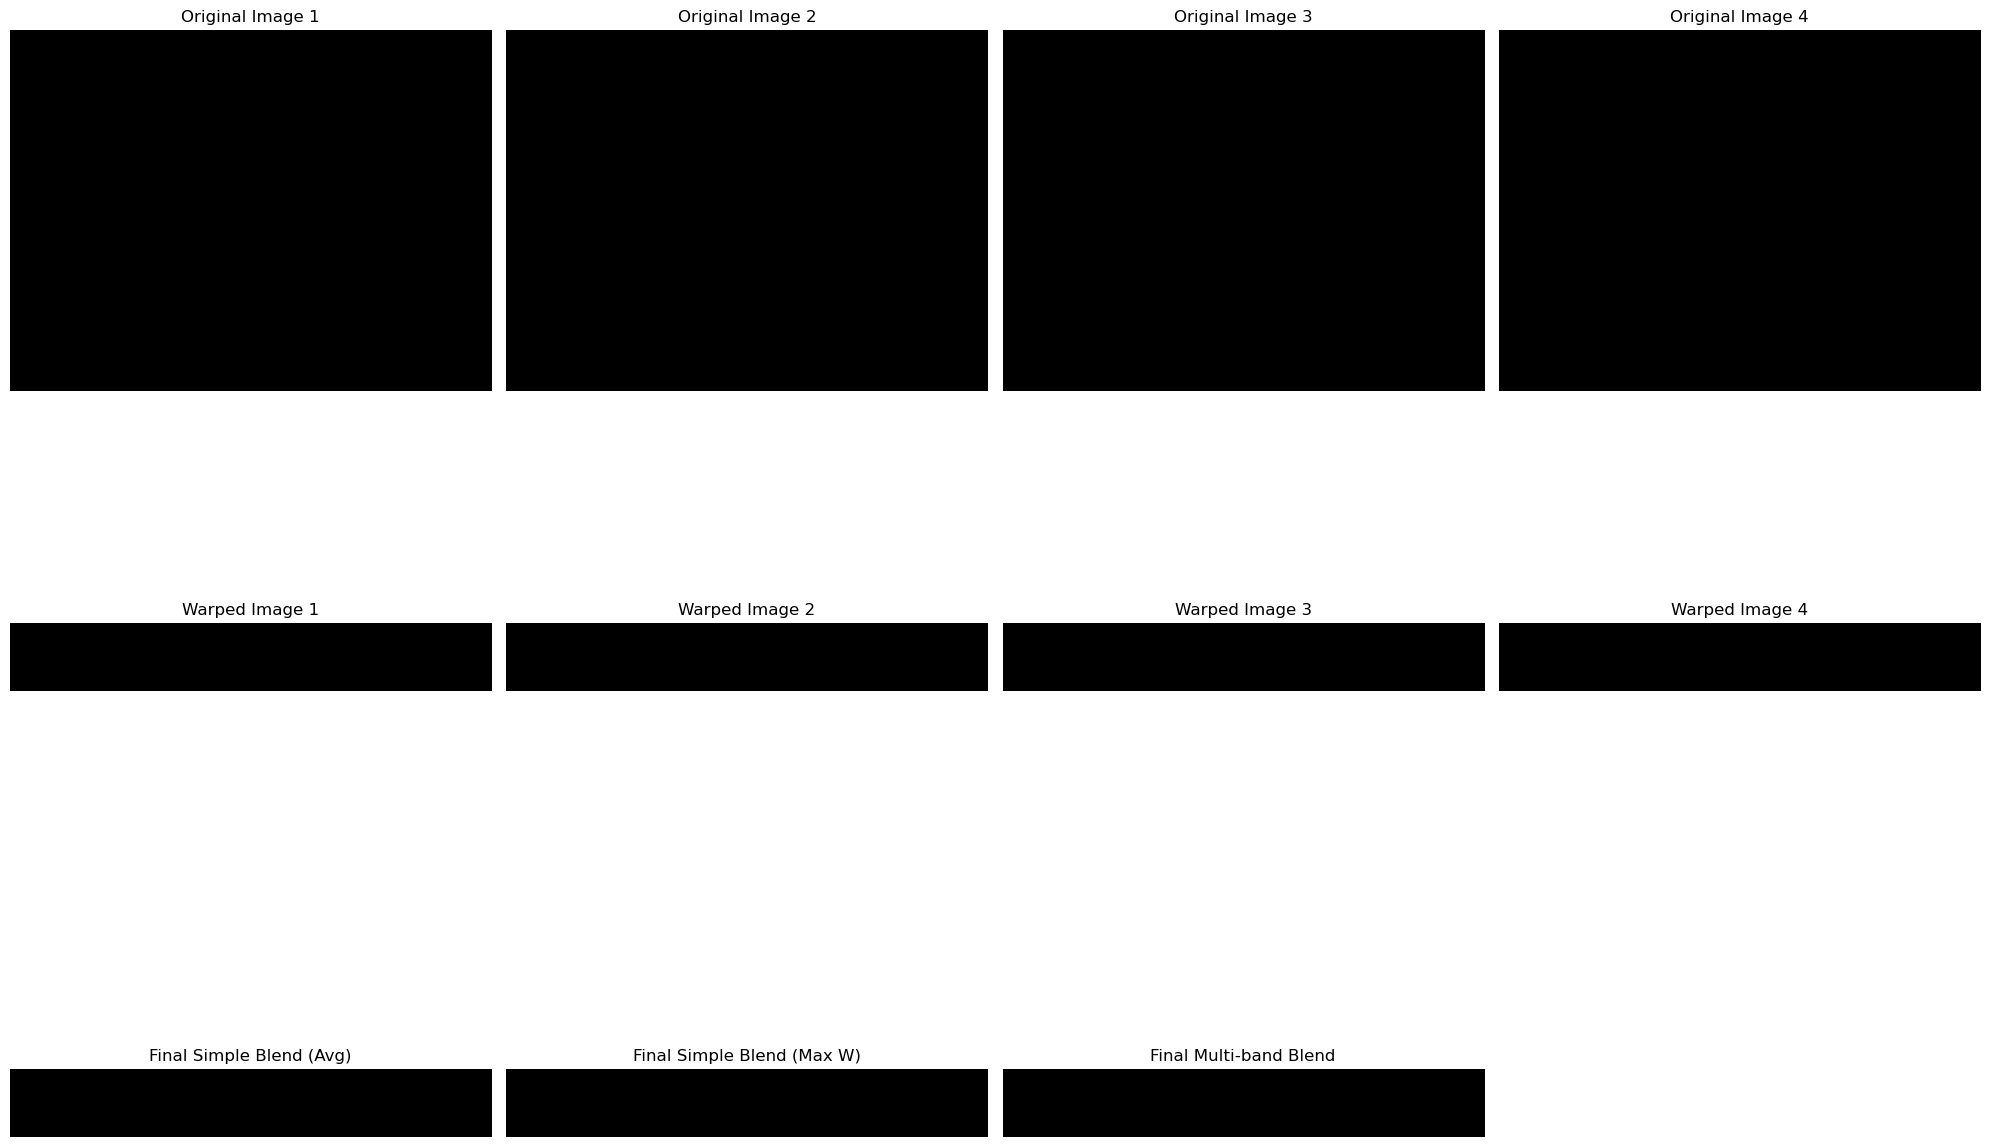

In [6]:
def run_panorama_stitching_for_n_images():
    print("\n--- Running Panorama Stitching for 4 Images ---")

    # Define image paths (ensure these paths are correct)
    dateien = [
        "data/stiching/bib_1.jpeg",
        "data/stiching/bib_2.jpeg",
        "data/stiching/bib_3.jpeg",
        "data/stiching/bib_4.jpeg"
    ]
    num_images = len(dateien)

    # Define image points for each house (ensure these are accurate)
    Haus1_pts_img = [[1520, 1077], [4513, 1221], [4581, 2961], [1381, 2885]]
    Haus2_pts_img = [[2389, 877], [3993, 837], [4017, 2557], [2465, 2577]]
    Haus3_pts_img = [[3309, 733], [4885, 761], [4921, 3737], [3153, 3561]] # Example, adjust
    Haus4_pts_img = [[1521, 689], [3817, 621], [3873, 2509], [1527, 2477]] # Example, adjust

    all_image_points_input = [
        np.array(Haus1_pts_img, dtype=np.float32),
        np.array(Haus2_pts_img, dtype=np.float32),
        np.array(Haus3_pts_img, dtype=np.float32),
        np.array(Haus4_pts_img, dtype=np.float32)
    ]

    # Define world coordinates for each house
    world_coords_h1 = np.array([[0, 0], [1000, 0], [1000, 600], [0, 600]], dtype=np.float32)
    world_coords_h2 = np.array([[1000, 0], [1800, 0], [1800, 600], [1000, 600]], dtype=np.float32)
    world_coords_h3 = np.array([[1000, 0], [1800, 0], [1800, 600], [1000, 600]], dtype=np.float32) # Adjust
    world_coords_h4 = np.array([[1800, 0], [2600, 0], [2600, 600], [1800, 600]], dtype=np.float32) # Adjust

    all_world_points_input = [world_coords_h1, world_coords_h2, world_coords_h3, world_coords_h4]

    images_orig = []
    images_float = []
    for i in range(num_images):
        img_path = dateien[i]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: File {img_path} not found. Creating dummy image.")
            # Ensure dummy image has consistent dimensions or adapt world coords accordingly
            img = np.zeros((600, 800, 3), dtype=np.uint8)
            cv2.imwrite(img_path, img) # Save dummy if you want to see it with visualize_points
        images_orig.append(img)
        images_float.append(img.astype(np.float32) / 255.0)

    # 1. Compute Homographies for each image to its world plane
    homographies = []
    for i in range(num_images):
        H = compute_homography(all_image_points_input[i], all_world_points_input[i])
        homographies.append(H)

    # 2. Determine overall panorama canvas size
    all_transformed_corners = []
    for i in range(num_images):
        h_orig, w_orig = images_orig[i].shape[:2]
        corners_orig = np.float32([[0,0], [0,h_orig-1], [w_orig-1,h_orig-1], [w_orig-1,0]]).reshape(-1,1,2)
        transformed_corners = cv2.perspectiveTransform(corners_orig, homographies[i])
        all_transformed_corners.append(transformed_corners)

    all_corners_stacked = np.concatenate(all_transformed_corners, axis=0)
    x_min, y_min = np.int32(all_corners_stacked.min(axis=0).ravel() - 0.5)
    x_max, y_max = np.int32(all_corners_stacked.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]],
                              [0, 0, 1]], dtype=np.float32)

    output_width = x_max - x_min
    output_height = y_max - y_min

    # Sanity check for output dimensions
    if not(0 < output_width < 20000 and 0 < output_height < 20000):
        print(f"Warning: Calculated output dimensions are extreme ({output_width}x{output_height}). Clamping.")
        # You might need to adjust these default clamping values or debug point correspondences
        output_width = max(1200, min(output_width, 8000))
        output_height = max(800, min(output_height, 8000))


    # 3. Warp all images and their initial weight maps to the final canvas
    warped_images = []
    warped_weights = []
    final_homographies = []

    for i in range(num_images):
        H_final = H_translation @ homographies[i]
        final_homographies.append(H_final)

        img_warped = cv2.warpPerspective(images_float[i], H_final, (output_width, output_height))
        warped_images.append(img_warped)

        h_orig, w_orig = images_orig[i].shape[:2]
        weights_orig = calculate_pixel_weights(h_orig, w_orig)
        weights_warped = cv2.warpPerspective(weights_orig.astype(np.float32), H_final, (output_width, output_height))
        weights_warped = np.clip(weights_warped, 0, 1)
        warped_weights.append(weights_warped)

    # 4. Iteratively blend images
    # Initialize with the first image
    current_panorama_simple_avg = warped_images[0].copy()
    current_weights_simple_avg = warped_weights[0].copy()

    current_panorama_simple_max = warped_images[0].copy()
    current_weights_simple_max = warped_weights[0].copy()

    current_panorama_multiband = warped_images[0].copy()
    current_weights_multiband = warped_weights[0].copy()

    blended_phs = []

    for i in range(1, num_images):
        print(f"Blending with image {i+1}...")
        img_next_warped = warped_images[i]
        weights_next_warped = warped_weights[i]

        # Simple Average Blending
        current_panorama_simple_avg, current_weights_simple_avg = blend_images_simple(
            current_panorama_simple_avg, current_weights_simple_avg,
            img_next_warped, weights_next_warped, method='weighted_average'
        )
        current_weights_simple_avg = np.clip(current_weights_simple_avg, 0, 1) # Ensure weights stay in [0,1]

        # Simple Max Weight Blending
        current_panorama_simple_max, current_weights_simple_max = blend_images_simple(
            current_panorama_simple_max, current_weights_simple_max,
            img_next_warped, weights_next_warped, method='max_weight'
        )
        current_weights_simple_max = np.clip(current_weights_simple_max, 0, 1)

        # Multi-band Blending
        current_panorama_multiband, current_weights_multiband, blended_hp = blend_images_multiband(
            current_panorama_multiband, current_weights_multiband,
            img_next_warped, weights_next_warped, low_pass_kernel_size=(21,21) # Kernel size might need tuning
        )
        blended_phs.append(blended_hp)
        current_weights_multiband = np.clip(current_weights_multiband, 0, 1)

   # 5. Display results
    plt.figure(figsize=(20, 15)) # Adjusted figure size

    # Plot original images
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1) # 3 rows, num_images columns
        display_img_orig = cv2.cvtColor(images_orig[i], cv2.COLOR_BGR2RGB) if len(images_orig[i].shape) == 3 and images_orig[i].shape[2] == 3 else images_orig[i]
        cmap_val = 'gray' if len(images_orig[i].shape) == 2 else None
        plt.imshow(display_img_orig, cmap=cmap_val)
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

    # Plot all warped images in the second row
    for i in range(num_images):
        plt.subplot(3, num_images, num_images + i + 1)
        display_warped = warped_images[i]
        # Convert BGR (OpenCV default) to RGB for Matplotlib display if it's a color image
        if len(display_warped.shape) == 3 and display_warped.shape[2] == 3:
            display_warped_rgb = display_warped[..., ::-1]
            plt.imshow(display_warped_rgb)
        else: # Grayscale
            plt.imshow(display_warped, cmap='gray')
        plt.title(f"Warped Image {i+1}")
        plt.axis('off')

    # Plot Blended Panoramas in the third row
    # Define the starting index for blended plots in the third row
    blended_plot_start_col = 1 # Start plotting blended results from the first column of the third row

    # Plot Final Simple Blend (Avg)
    plt.subplot(3, num_images, 2 * num_images + blended_plot_start_col)
    display_blend_avg = current_panorama_simple_avg
    if len(display_blend_avg.shape) == 3 and display_blend_avg.shape[2] == 3:
        display_blend_avg_rgb = display_blend_avg[..., ::-1]
        plt.imshow(display_blend_avg_rgb)
    else:
        plt.imshow(display_blend_avg, cmap='gray')
    plt.title("Final Simple Blend (Avg)")
    plt.axis('off')

    # Plot Final Simple Blend (Max W) - ensure there's space
    if blended_plot_start_col + 1 <= num_images:
        plt.subplot(3, num_images, 2 * num_images + blended_plot_start_col + 1)
        display_blend_max = current_panorama_simple_max
        if len(display_blend_max.shape) == 3 and display_blend_max.shape[2] == 3:
            display_blend_max_rgb = display_blend_max[..., ::-1]
            plt.imshow(display_blend_max_rgb)
        else:
            plt.imshow(display_blend_max, cmap='gray')
        plt.title("Final Simple Blend (Max W)")
        plt.axis('off')

    # Plot Final Multi-band Blend - ensure there's space
    if blended_plot_start_col + 2 <= num_images:
        plt.subplot(3, num_images, 2 * num_images + blended_plot_start_col + 2)
        display_blend_multi = current_panorama_multiband
        if len(display_blend_multi.shape) == 3 and display_blend_multi.shape[2] == 3:
            display_blend_multi_rgb = display_blend_multi[..., ::-1]
            plt.imshow(display_blend_multi_rgb)
        else:
            plt.imshow(display_blend_multi, cmap='gray')
        plt.title("Final Multi-band Blend")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return blended_phs


if __name__ == '__main__':
    # Define image points for visualization if needed (using the same as in the main function)
    Haus1_pts_img_vis = [[1520, 1077], [4513, 1221], [4581, 2961], [1381, 2885]]
    Haus2_pts_img_vis = [[2389, 877], [3993, 837], [4017, 2557], [2465, 2577]]
    Haus3_pts_img_vis = [[3309, 733], [4885, 761], [4921, 3737], [3153, 3561]]
    Haus4_pts_img_vis = [[1521, 689], [3817, 621], [3873, 2509], [1527, 2477]]

    all_image_points_for_viz = [
        np.array(Haus1_pts_img_vis, dtype=np.float32),
        np.array(Haus2_pts_img_vis, dtype=np.float32),
        np.array(Haus3_pts_img_vis, dtype=np.float32),
        np.array(Haus4_pts_img_vis, dtype=np.float32)
    ]
    file_paths_for_viz = [
        "../data/stiching/bib_1.jpeg",
        "../data/stiching/bib_2.jpeg",
        "../data/stiching/bib_3.jpeg",
        "../data/stiching/bib_4.jpeg"
    ]

    # Create dummy files if they don't exist, so visualize_points doesn't fail before main run
    for fname in file_paths_for_viz:
        try:
            with open(fname, 'rb') as f:
                pass
        except FileNotFoundError:
            print(f"Warning: File {fname} not found for visualization pre-check. Creating dummy image.")
            dummy_img = np.zeros((100, 100, 3), dtype=np.uint8) # Small dummy
            cv2.imwrite(fname, dummy_img)

    visualize_points(all_image_points_for_viz, file_paths_for_viz)
    blended_phs = run_panorama_stitching_for_n_images()

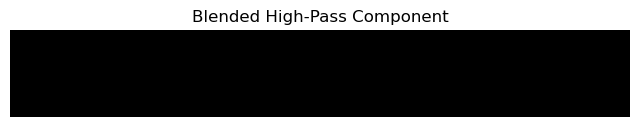

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assume blended_hp is the high-pass result returned by blend_images_multiband

# 1. If blended_hp is float in roughly [–1, +1] (or small values), normalize to [0,1] for display:
hp_min, hp_max = blended_phs[-1].min(), blended_phs[-1].max()
blended_hp_vis = ( blended_phs[-1] - hp_min) / (hp_max - hp_min + 1e-12)

# 2. If you want to view it with matplotlib:
plt.figure(figsize=(8, 8))
plt.imshow(blended_hp_vis, cmap='gray', vmin=0, vmax=1)
plt.title('Blended High-Pass Component')
plt.axis('off')
plt.show()

# 3. Alternatively, to use OpenCV’s imshow (convert to 8-bit):
blended_hp_8u = (blended_hp_vis * 255).astype(np.uint8)
cv2.imshow('Blended High-Pass', blended_hp_8u)
cv2.waitKey(0)
cv2.destroyAllWindows()
